Bu versiyonda ver001 text pross. geliştirildi ve skorun 0.06 puan iyişleştiği gözlendi..

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from nltk.util import ngrams
from collections import defaultdict
from collections import  Counter
stop=set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize
import gensim
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix


pd.set_option('display.max_rows', 5000000)
pd.set_option('display.max_columns', 5000000)
pd.set_option('display.width', 10000000)
pd.set_option('display.max_colwidth', 4000)

Using TensorFlow backend.


In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample = pd.read_csv("sample.csv")

df=pd.concat([train,test])
df.drop(["label", "id"],axis=1,inplace=True)

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


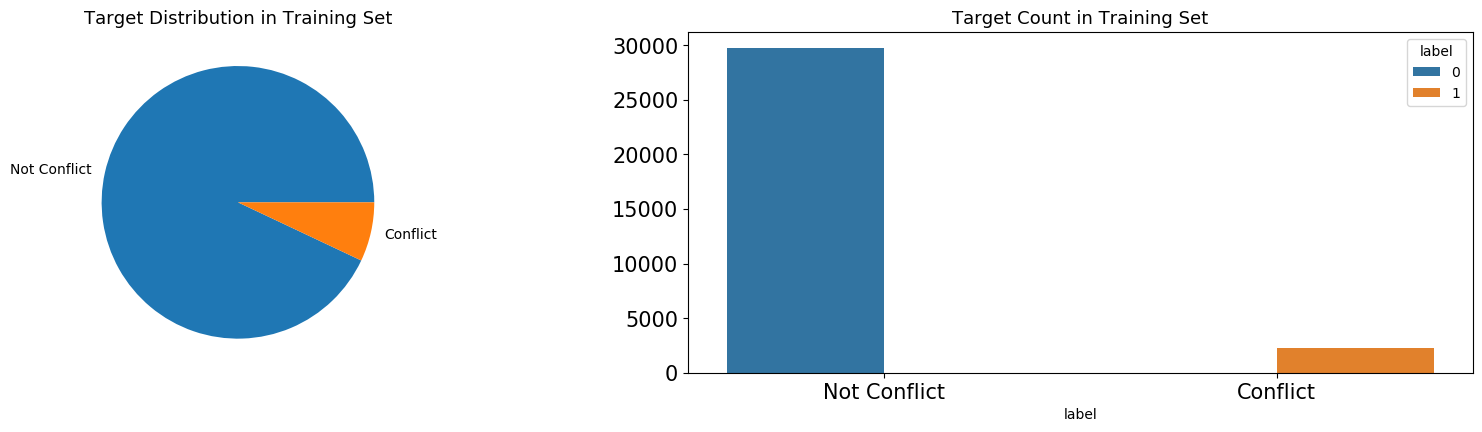

In [4]:
fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)
plt.tight_layout()

train.groupby('label').count()['id'].plot(kind='pie', ax=axes[0], labels=['Not Conflict', 'Conflict'])
sns.countplot(x=train['label'], hue=train['label'], ax=axes[1])

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[1].set_xticklabels(['Not Conflict', 'Conflict'])
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Target Distribution in Training Set', fontsize=13)
axes[1].set_title('Target Count in Training Set', fontsize=13)

plt.show()

In [5]:
# @ ile başlayan kelimelerin hepsini dopladık

def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt    

df['tweet'] = np.vectorize(remove_pattern)(df['tweet'], "@[\w]*")

In [6]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [7]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

In [8]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

In [61]:
# az geçen charları bulman ve sayan
"""
sil2 = []
for i in df["tweet"]:
    for j in (i.split()):
        
        sil2.append(j)




sil3 = pd.DataFrame(sil2, columns = ['tweet'])

sil4 = sil3.groupby(['tweet']).size().reset_index()

sil5 = sil4[sil4[0]<50]

"""

In [9]:
df['tweet']=df['tweet'].apply(lambda x: remove_emoji(x))

In [10]:
df['tweet']=df['tweet'].apply(lambda x : remove_punct(x))

In [11]:
df['tweet']=df['tweet'].apply(lambda x : remove_URL(x))

In [12]:
# sadece string karekterler kaldı
df["tweet"]=df["tweet"].str.replace("[^A-Za-z]"," ")


In [13]:
# 1 harften oluşan kelimeleri dropladık

df["tweet"] = df["tweet"].str.replace(r"\b[a-zA-Z]\b", "")

In [14]:
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
sw = stopwords.words('english')
df['tweet'] = df['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in sw))


In [15]:
from textblob import Word
#nltk.download('wordnet')
df['tweet'] = df['tweet'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()])) 

In [65]:
sil = pd.Series(' '.join(df['tweet']).split()).value_counts()[-43000:]
df['tweet'] = df['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in sil))

In [71]:
#df[df['tweet'].str.contains("tcot")]

In [72]:
train=df[:train.shape[0]]
test=df[train.shape[0]:]

In [74]:
target = pd.read_csv("train.csv")

In [75]:
train_x, test_x, train_y, test_y = train_test_split(train["tweet"],
                                                                   target["label"], 
                                                                    random_state = 1)

In [77]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_word_vectorizer = TfidfVectorizer()
tf_idf_word_vectorizer.fit_transform(train_x)

<23971x5782 sparse matrix of type '<class 'numpy.float64'>'
	with 144128 stored elements in Compressed Sparse Row format>

In [78]:
x_train_tf_idf_word = tf_idf_word_vectorizer.transform(train_x)

In [79]:
x_test_tf_idf_word = tf_idf_word_vectorizer.transform(test_x)

In [81]:
test = test["tweet"]
test = tf_idf_word_vectorizer.transform(test)

In [83]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf_model = rf.fit(x_train_tf_idf_word,train_y)

In [84]:
accuracy = cross_val_score(rf_model, 
                                           x_test_tf_idf_word, 
                                           test_y, scoring="f1",
                                           cv = 3).mean()

print("Word-Level TF-IDF Doğruluk Oranı:", accuracy)

Word-Level TF-IDF Doğruluk Oranı: 0.4322631689992264


In [85]:
y_pred_rf = rf_model.predict(x_test_tf_idf_word)

In [86]:
confusion_matrix(test_y, y_pred_rf)

array([[7389,   62],
       [ 243,  297]], dtype=int64)

In [87]:
submission=pd.read_csv('sample.csv')

In [88]:
y_pred_rf=rf_model.predict(test)
sub=pd.DataFrame({'id':submission['id'].values.tolist(),'label':y_pred_rf})
sub.to_csv('180620_1.csv',index=False)
